In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pickle
from modules_gd.model import VAE

In [15]:
MSA_id = "COG154-l150-s0.5"
model = "model_ld2_wd0_epoch30_2024-08-01"
msa_path = f"data/simulations/msas/1250/{MSA_id}_msa.dat"
embeddings_path = f"embeddings/{MSA_id}/{model}_anc-embeddings.csv"

In [18]:
with open(f"data/simulations/processed/{MSA_id}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)

# now let's create the inverse mapping
# In our integer encoding of proteins, we've encoded several different amino acid characters as 0
# For decoding purposes, we will decode all 0's as '-'
del aa_index['.'], aa_index['X'], aa_index['B'], aa_index['Z'], aa_index['J'], 


idx_to_aa_dict = {}
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k

# Decode reconstructed embeddings

Get ancestral embeddings that were saved from R script

In [19]:
recon_embeds = pd.read_csv(embeddings_path, index_col=0)
anc_id = [str(id) for id in recon_embeds.index]
recon_embeds

,dim0,dim1
1251,0.349485,-0.198116
1252,0.351691,-0.240611
1253,0.348236,-0.262596
1254,0.250835,-0.223865
1255,0.206223,-0.219734
...,...,...
2494,0.083328,-0.136863
2495,0.199156,-0.161852
2496,0.034780,-0.100295
2497,0.033327,-0.104553


Load model that was used to produce the embeddings at the tips and

In [20]:
nl, nc = 150, 21
model_path = f"saved_models/{MSA_id}/{model}.pt"
model = VAE(nl = nl, nc = nc, dim_latent_vars=2) # initiate to have the right architecture for loading
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Decode embeddings back to sequences

In [21]:
# convert to torch tensor
mu = torch.tensor(recon_embeds.values , dtype=torch.float32)
# now we decode
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
# Now we covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = torch.argmax(p, -1)
max_prob_idx.shape

torch.Size([1229, 150])

Decode the integer `max_prob_idx` to character

In [22]:
max_prob_idx = max_prob_idx.numpy()
recon_seqs = []
for i in range(len(max_prob_idx)):
    recon_seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    recon_seqs.append("".join(recon_seq))
# print every 10 sequences to compare with real sequences
recon_seqs[::10]

['KKDWFESLMAQFILGALNVAAEEYFAEAANANTQVEATYTRYGPMGLTSTSQQVVGLLGLVVRAVAHQSTKARSLNKNDIHCGARIDQTVETAFVMMDLLESSKVNEHILRGHVAEYTENNALRIFELSVKLGPEYYQRLPVRLILAVGS',
 'KKEWFESLMAQFILGALNVAAEEYFAEAANTNTQVEVTYTRYGPMGLTSTSQRVVGLQGIVVRAVAFQSTKARSLNKNDIHCGAHIDQTVETAFVMMDLLKSSGVNEQLLKGHVAEYTENNALRIFEQSVKMGPEYYQRLPLRLIIAIGS',
 'KKEWFESLMAKFILGALNVSAEEYFAEAANTNTQVETTYTRYGPMGLDSTSQRVVGLQGIVVRAVAFQSTKARSLNKDDIHCGAHIDQTTDTAFVMMDLLKSSGVSEQLLKGHVAEYTENNALQIFEQNVKMGPEYYQRLPLRLIIAIGS',
 'KKEWFESLMAQFILGALNVAAEEYFAEAANTNTQVETTYTRYGPMGLDSTSQRVVGLQGIVVRAVAFQSTKARSLNKDDIHCGAHIDQTVDTAFVMMDLLKSSGVNEQLLKGHVAEYTENNALQIFEQSVKMGPEYYQRLPLRLILAIGS',
 'KKDWFEALLAQFILGALNVSAEEYFAEAANTNTQVPVTYTRYGPMGLSSTSQQVVGLLGVVVRAVPLQSTKARSLNKNDIHCGAHINQTTETAFVMMDLLKSSGVNEHVLKGHVAEYTENNALRIFEQSVKMGPEYYQRIPVRLIIAIGS',
 'KKEWFEPLLAQFVMGSLNVSSEEYFTEAPNTNTEVPVAYTRYGPMGLSSVSQNVVGIEGMIIRAVPFQAVKAKPLNTNDIHNGAHIDQNCEVAFVMEDFLKSDGCNEQVMPGQISEYTENEALQIYEHNVKMGPMNYQHIPLRVIVQIGS',
 'KKEWFEPLLAQFVIGSLNVSSEEYFTEAPNTRTQVPVAYTRYGPMGLSSVSQNIVGIEGMIIRAVAFQ

# Compare to real ancestral sequences that we simuated

Load real sequences

In [23]:
real_seqs_dict = {}
with open(msa_path, 'r') as msa:
    # Skips text before the beginning of the interesting block:
    for line in msa:
        if line.strip() == '2497 150':  # Change to more robust test
            break
    # Read only ancestral sequences
    for line in msa:  # This keeps reading the file
        id, seq = line.split()
        if id[0] != 'N':
            real_seqs_dict[id] = seq
print(len(real_seqs_dict))

1248


Order them according to the index from `recon_embeds`

In [24]:
# order real seqs according `anc_id`
real_seqs = [real_seqs_dict[k] for k in anc_id]
len(real_seqs)

1229

In [25]:
real_seqs[::10]

['KKDWVASLMKQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGIVVRVVAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHVLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLIIAVGQ',
 'GRDFFESLISQYILHALNVSTEEYYQEAAATNVQVEVTYTQYNPMGLDPNNEKIIGMQGVIVRAVPLVATAARSLNKDEIHCGTAIDQLNQTAYVKMELIQTNGVNESVAKGHVHEYTENNALRVFQKNIKLGPEYYQRLPNRLIVDEGS',
 'KAEWFESIMAQAILGALNVSAEEYFPSAANPTTQVETSYTRMGPMGLDSYSQKTVGVRGIVVSVVPFQRLKARSLNKDDIHMGAHVDDTIETAFAMLDLLKSSAVSDGLLKGFAGEFTENNALQVFEHSVKMGPEYYQRLPQGLIIAIAS',
 'KKEWFETIMAQFIVGALNVSAEEYFCSAANPTTQVETSYTRYGPMGLDHTSQKTVGVRGIVVRVVPFQSQKARSLNKDDIHCGAHVDDTTETAFAMLDLLKSSAVSERLLKGFASEYTENNALQVFEHSVTMGPEYYQRLAQRLIIAIAS',
 'KKEWFEALMAQFVMGALNVSAEEYFAEAANTNTEVPVTYTRYGPMGLSSTSQNVVGLEGVIVRAVPFQATKARPLNKNDIHNGAHIDQTTETAFVMEDFLKSDGVNEQILKGHIAEYTENNALQIFEQNVKMGPEYYQHIPLRLIIAIGS',
 'KKEWFEPLLAAFVMGSLNLSSENLFTEVPNTNSSIPVANTRWGPSGLSSVSQNIVGIEAIVVDTVPFQAVSLKPLNTNDIHNGAHLDHNCEVAFVMEDFVKSEGNNLQQMPGQIGPYTENDALQIYEDKVKMGPWNYEHIPFRTIFQVAS',
 'KKEWFEPLLAQFVIGSLNVSSEEYFTEAPNTRTQVPVAYTRYGGMGLSSPSQNIVGIEGMIIRAVPFQ

correct: 151131
total: 184350
Percentage correct: 81.98


(array([  2.,   2.,   1.,   1.,   8.,   4.,   5.,   3.,  17.,  25.,  26.,
         21.,  29.,  48.,  39.,  63.,  69.,  69.,  47.,  64.,  90.,  89.,
         51.,  81.,  90., 102.,  45.,  70.,  50.,  18.]),
 array([0.45333333, 0.47155556, 0.48977778, 0.508     , 0.52622222,
        0.54444444, 0.56266667, 0.58088889, 0.59911111, 0.61733333,
        0.63555556, 0.65377778, 0.672     , 0.69022222, 0.70844444,
        0.72666667, 0.74488889, 0.76311111, 0.78133333, 0.79955556,
        0.81777778, 0.836     , 0.85422222, 0.87244444, 0.89066667,
        0.90888889, 0.92711111, 0.94533333, 0.96355556, 0.98177778,
        1.        ]),
 <BarContainer object of 30 artists>)

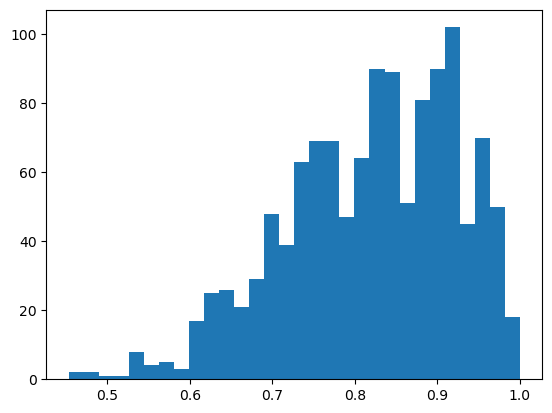

In [26]:
correct = 0
total = 0
acc = []
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  n_correct = sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  correct += n_correct
  total += len(real_seq)
  acc.append(n_correct)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")
acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)